### Baselines

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
import random
import timm
import numpy as np
import json

device = "cuda" if torch.cuda.is_available() else "cpu"

weights = models.ResNet50_Weights.DEFAULT
transform = weights.transforms()

train_dataset = datasets.STL10(
    root="./data", split="train", download=True, transform=transform
)
test_dataset = datasets.STL10(
    root="./data", split="test", download=True, transform=transform
)

In [3]:
BATCH_SIZE = 128
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [66]:
resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
for param in resnet.parameters():
    param.requires_grad = False
resnet.fc = nn.Linear(resnet.fc.in_features, 10)
resnet = resnet.to(device)

In [67]:
resnet_optimizer = optim.Adam(resnet.fc.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

resnet_train_losses = []
resnet_test_losses = []
resnet_train_accs = []
resnet_test_accs = []

NUM_EPOCHS = 3
for epoch in range(NUM_EPOCHS):
    resnet.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    train_pbar = tqdm(
        train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [ResNet Training]"
    )
    for data, target in train_pbar:
        data, target = data.to(device), target.to(device)

        resnet_optimizer.zero_grad()
        output = resnet(data)
        loss = criterion(output, target)
        loss.backward()
        resnet_optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total_train += target.size(0)
        correct_train += (predicted == target).sum().item()
        train_pbar.set_postfix(
            {
                "loss": f"{running_loss/len(train_loader):.4f}",
                "acc": f"{100 * correct_train / total_train:.2f}%",
            }
        )

    epoch_train_loss = running_loss / len(train_loader)
    epoch_train_acc = correct_train / total_train
    resnet_train_losses.append(epoch_train_loss)
    resnet_train_accs.append(epoch_train_acc)

    resnet.eval()
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        test_pbar = tqdm(
            test_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [ResNet Testing]"
        )
        for data, target in test_pbar:
            data, target = data.to(device), target.to(device)
            output = resnet(data)
            loss = criterion(output, target)
            test_loss += loss.item()

            _, predicted = torch.max(output.data, 1)
            total_test += target.size(0)
            correct_test += (predicted == target).sum().item()
            test_pbar.set_postfix(
                {
                    "loss": f"{test_loss/len(test_loader):.4f}",
                    "acc": f"{100 * correct_test / total_test:.2f}%",
                }
            )

    epoch_test_loss = test_loss / len(test_loader)
    epoch_test_acc = correct_test / total_test
    resnet_test_losses.append(epoch_test_loss)
    resnet_test_accs.append(epoch_test_acc)

    print(
        f"Epoch {epoch+1} Summary -> Train Acc: {epoch_train_acc*100:.2f}% | Test Acc: {epoch_test_acc*100:.2f}%"
    )

Epoch 1/3 [ResNet Testing]: 100%|██████████| 63/63 [00:29<00:00,  2.14it/s, loss=0.6749, acc=94.19%]


Epoch 1 Summary -> Train Acc: 79.66% | Test Acc: 94.19%


Epoch 2/3 [ResNet Testing]: 100%|██████████| 63/63 [00:35<00:00,  1.78it/s, loss=0.3539, acc=95.41%]


Epoch 2 Summary -> Train Acc: 95.76% | Test Acc: 95.41%


Epoch 3/3 [ResNet Testing]: 100%|██████████| 63/63 [00:29<00:00,  2.13it/s, loss=0.2587, acc=96.10%]

Epoch 3 Summary -> Train Acc: 96.60% | Test Acc: 96.10%


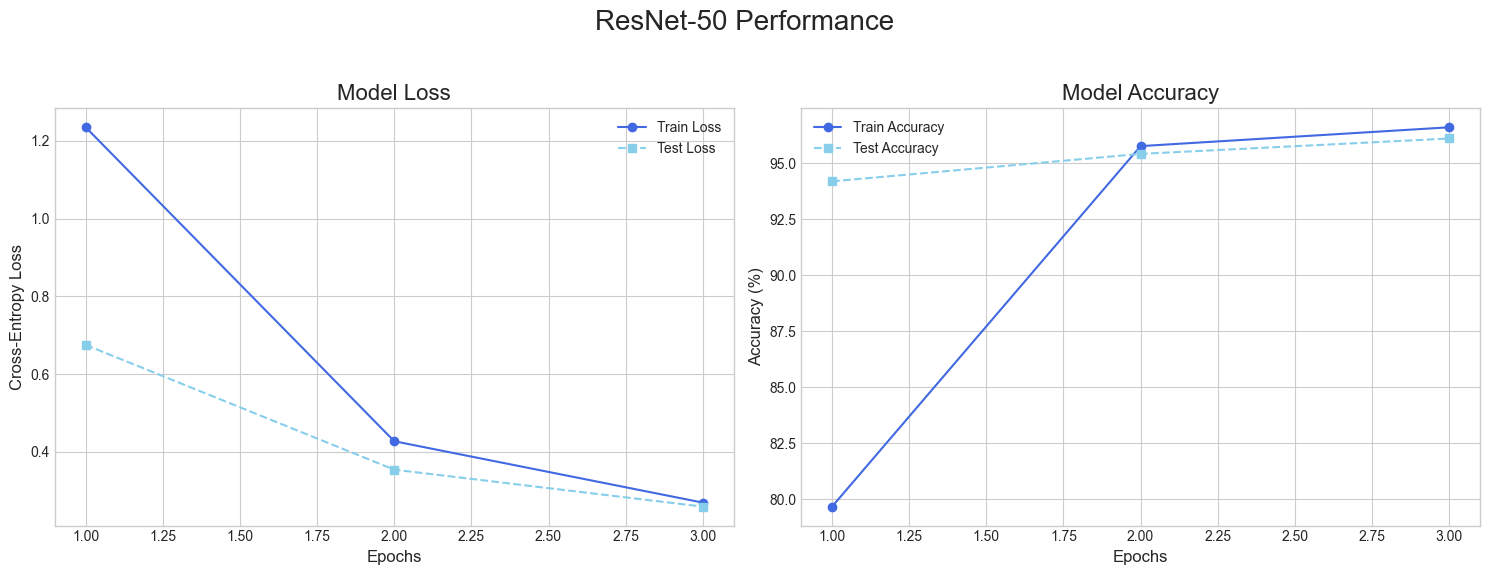

In [68]:
epochs = range(1, NUM_EPOCHS + 1)
plt.style.use("seaborn-v0_8-whitegrid")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle("ResNet-50 Performance", fontsize=20)

# Plotting Loss
ax1.plot(epochs, resnet_train_losses, "o-", label="Train Loss", color="royalblue")
ax1.plot(epochs, resnet_test_losses, "s--", label="Test Loss", color="skyblue")
ax1.set_title("Model Loss", fontsize=16)
ax1.set_xlabel("Epochs", fontsize=12)
ax1.set_ylabel("Cross-Entropy Loss", fontsize=12)
ax1.legend()

# Plotting Accuracy
ax2.plot(
    epochs,
    [acc * 100 for acc in resnet_train_accs],
    "o-",
    label="Train Accuracy",
    color="royalblue",
)
ax2.plot(
    epochs,
    [acc * 100 for acc in resnet_test_accs],
    "s--",
    label="Test Accuracy",
    color="skyblue",
)
ax2.set_title("Model Accuracy", fontsize=16)
ax2.set_xlabel("Epochs", fontsize=12)
ax2.set_ylabel("Accuracy (%)", fontsize=12)
ax2.legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
# torch.save(resnet.state_dict(), "resnet50_stl10.pth")

resnet = models.resnet50(weights=None)
for param in resnet.parameters():
    param.requires_grad = False
resnet.fc = nn.Linear(resnet.fc.in_features, 10)
resnet.load_state_dict(torch.load("resnet50_stl10.pth"))
resnet = resnet.to(device)

In [13]:
vit = timm.create_model('vit_small_patch16_224', pretrained=True)

for param in vit.parameters():
    param.requires_grad = False
vit.head = nn.Linear(vit.head.in_features, 10)
vit = vit.to(device)

In [ ]:
vit_optimizer = optim.Adam(vit.head.parameters(), lr=1e-3)

vit_train_losses = []
vit_test_losses = []
vit_train_accs = []
vit_test_accs = []

NUM_EPOCHS = 2
for epoch in range(NUM_EPOCHS):
    vit.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [ViT Training]")
    for data, target in train_pbar:
        data, target = data.to(device), target.to(device)

        vit_optimizer.zero_grad()
        output = vit(data)
        loss = criterion(output, target)
        loss.backward()
        vit_optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total_train += target.size(0)
        correct_train += (predicted == target).sum().item()
        train_pbar.set_postfix(
            {
                "loss": f"{running_loss/len(train_loader):.4f}",
                "acc": f"{100 * correct_train / total_train:.2f}%",
            }
        )

    epoch_train_loss = running_loss / len(train_loader)
    epoch_train_acc = correct_train / total_train
    vit_train_losses.append(epoch_train_loss)
    vit_train_accs.append(epoch_train_acc)

    vit.eval()
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        test_pbar = tqdm(
            test_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [ViT Testing]"
        )
        for data, target in test_pbar:
            data, target = data.to(device), target.to(device)
            output = vit(data)
            loss = criterion(output, target)
            test_loss += loss.item()

            _, predicted = torch.max(output.data, 1)
            total_test += target.size(0)
            correct_test += (predicted == target).sum().item()
            test_pbar.set_postfix(
                {
                    "loss": f"{test_loss/len(test_loader):.4f}",
                    "acc": f"{100 * correct_test / total_test:.2f}%",
                }
            )

    epoch_test_loss = test_loss / len(test_loader)
    epoch_test_acc = correct_test / total_test
    vit_test_losses.append(epoch_test_loss)
    vit_test_accs.append(epoch_test_acc)

    print(
        f"Epoch {epoch+1} Summary -> Train Acc: {epoch_train_acc*100:.2f}% | Test Acc: {epoch_test_acc*100:.2f}%"
    )

Epoch 1/2 [ViT Testing]: 100%|██████████| 63/63 [00:26<00:00,  2.38it/s, loss=0.1321, acc=96.80%]


Epoch 1 Summary -> Train Acc: 79.18% | Test Acc: 96.80%


Epoch 2/2 [ViT Testing]: 100%|██████████| 63/63 [00:34<00:00,  1.82it/s, loss=0.0927, acc=97.51%]

Epoch 2 Summary -> Train Acc: 97.58% | Test Acc: 97.51%


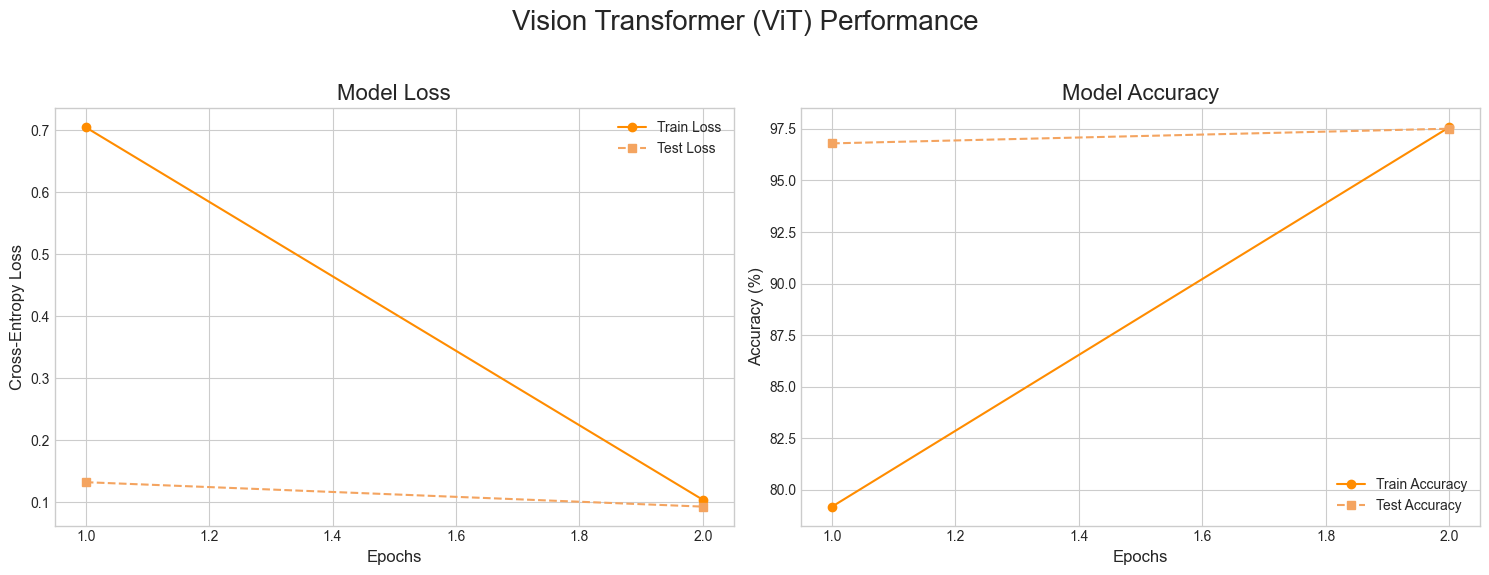

In [ ]:
epochs = range(1, NUM_EPOCHS + 1)
plt.style.use("seaborn-v0_8-whitegrid")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle("Vision Transformer (ViT) Performance", fontsize=20)

# Plotting Loss
ax1.plot(epochs, vit_train_losses, "o-", label="Train Loss", color="darkorange")
ax1.plot(epochs, vit_test_losses, "s--", label="Test Loss", color="sandybrown")
ax1.set_title("Model Loss", fontsize=16)
ax1.set_xlabel("Epochs", fontsize=12)
ax1.set_ylabel("Cross-Entropy Loss", fontsize=12)
ax1.legend()

# Plotting Accuracy
ax2.plot(
    epochs,
    [acc * 100 for acc in vit_train_accs],
    "o-",
    label="Train Accuracy",
    color="darkorange",
)
ax2.plot(
    epochs,
    [acc * 100 for acc in vit_test_accs],
    "s--",
    label="Test Accuracy",
    color="sandybrown",
)
ax2.set_title("Model Accuracy", fontsize=16)
ax2.set_xlabel("Epochs", fontsize=12)
ax2.set_ylabel("Accuracy (%)", fontsize=12)
ax2.legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
# torch.save(vit.state_dict(), "vit_stl10.pth")

vit = timm.create_model('vit_small_patch16_224', pretrained=False)
for param in vit.parameters():
    param.requires_grad = False
vit.head = nn.Linear(vit.head.in_features, 10)
vit.load_state_dict(torch.load("vit_stl10.pth"))
vit = vit.to(device)


### Color Bias

In [ ]:
grayscale_transform = transforms.Compose(
    [
        transforms.Grayscale(num_output_channels=3),
        transform,
    ]
)
grayscale_test_dataset = datasets.STL10(
    root="./data", split="test", download=True, transform=grayscale_transform
)

grayscale_test_loader = DataLoader(
    grayscale_test_dataset, batch_size=BATCH_SIZE, shuffle=False
)

In [71]:
resnet.eval()
correct_test_resnet = 0
total_test_resnet = 0
with torch.no_grad():
    pbar_resnet = tqdm(
        grayscale_test_loader, desc="Evaluating ResNet-50 on Grayscale Test Set"
    )
    for data, target in pbar_resnet:
        data, target = data.to(device), target.to(device)
        output = resnet(data)
        _, predicted = torch.max(output.data, 1)
        total_test_resnet += target.size(0)
        correct_test_resnet += (predicted == target).sum().item()
        pbar_resnet.set_postfix(
            {"accuracy": f"{100 * correct_test_resnet / total_test_resnet:.2f}%"}
        )
resnet_grayscale_acc = 100 * correct_test_resnet / total_test_resnet
print(f"Accuracy of ResNet-50 on Grayscale Test Set: {resnet_grayscale_acc:.2f}%")

Evaluating ResNet-50 on Grayscale Test Set: 100%|██████████| 63/63 [00:34<00:00,  1.81it/s, accuracy=92.17%]

Accuracy of ResNet-50 on Grayscale Test Set: 92.17%


In [72]:
vit.eval()
correct_test_vit = 0
total_test_vit = 0
with torch.no_grad():
    pbar_vit = tqdm(grayscale_test_loader, desc="Evaluating ViT on Grayscale Test Set")
    for data, target in pbar_vit:
        data, target = data.to(device), target.to(device)
        output = vit(data)
        _, predicted = torch.max(output.data, 1)
        total_test_vit += target.size(0)
        correct_test_vit += (predicted == target).sum().item()
        pbar_vit.set_postfix(
            {"accuracy": f"{100 * correct_test_vit / total_test_vit:.2f}%"}
        )
vit_grayscale_acc = 100 * correct_test_vit / total_test_vit
print(f"Accuracy of ViT on Grayscale Test Set: {vit_grayscale_acc:.2f}%")

Evaluating ViT on Grayscale Test Set: 100%|██████████| 63/63 [00:29<00:00,  2.14it/s, accuracy=92.72%]

Accuracy of ViT on Grayscale Test Set: 92.72%


### Cue Conflict

In [119]:
cue_conflict_dir = "data/cue_conflict_dataset"
cue_conflict_dataset = datasets.ImageFolder(
    root=cue_conflict_dir,
    transform=transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
        ]
    ),
)
cue_conflict_loader = DataLoader(
    cue_conflict_dataset, batch_size=BATCH_SIZE, shuffle=False
)

In [ ]:
def calculate_shape_dominance(model, data_loader, model_name):
    """
    Evaluates a model on the cue-conflict dataset and calculates its shape dominance.
    """
    model.eval()
    shape_match_count = 0
    total_images = 0
    
    pbar = tqdm(data_loader, desc=f"Evaluating {model_name} on Cue-Conflict Set")
    
    with torch.no_grad():
        for data, target in pbar:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            
            shape_match_count += (predicted == target).sum().item()
            total_images += target.size(0)
            
            pbar.set_postfix({'shape_accuracy': f"{100 * shape_match_count / total_images:.2f}%"})

    shape_dominance = (shape_match_count / total_images) * 100
    print(f"\n--- {model_name} Results ---")
    print(f"Correctly classified by shape: {shape_match_count}")
    print(f"Total images evaluated: {total_images}")
    print(f"Shape Dominance: {shape_dominance:.2f}%")
    
    return shape_dominance

resnet_shape_dominance = calculate_shape_dominance(resnet, cue_conflict_loader, "ResNet-50")
vit_shape_dominance = calculate_shape_dominance(vit, cue_conflict_loader, "Vision Transformer (ViT)")

Evaluating ResNet-50 on Cue-Conflict Set: 100%|██████████| 4/4 [00:01<00:00,  2.33it/s, shape_accuracy=15.50%]



--- ResNet-50 Results ---
Correctly classified by shape: 62
Total images evaluated: 400
Shape Dominance: 15.50%


Evaluating Vision Transformer (ViT) on Cue-Conflict Set: 100%|██████████| 4/4 [00:01<00:00,  2.62it/s, shape_accuracy=53.00%]


--- Vision Transformer (ViT) Results ---
Correctly classified by shape: 212
Total images evaluated: 400
Shape Dominance: 53.00%


### Translation

In [26]:
print(transform)

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [73]:
translation_transform = transforms.Compose(
    [
        transforms.RandomAffine(degrees=0, translate=(0.4, 0.4)),
        transform,
    ]
)

translated_test_dataset = datasets.STL10(
    root="./data", split="test", download=True, transform=translation_transform
)
translated_test_loader = DataLoader(
    translated_test_dataset, batch_size=BATCH_SIZE, shuffle=False
)

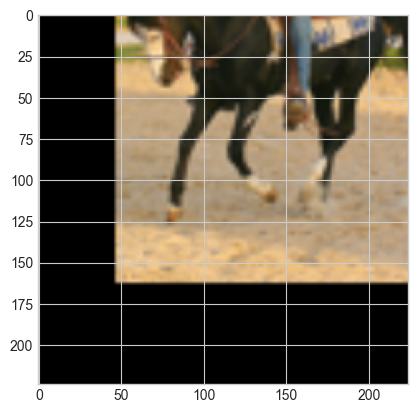

In [74]:
data, target = next(iter(translated_test_loader))
img = data[0].permute(1, 2, 0).cpu().numpy()
plt.imshow((img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])).clip(0, 1))

In [ ]:
resnet.eval()
original_preds_resnet = []
with torch.no_grad():
    for data, _ in tqdm(test_loader, desc="Getting Original Preds (ResNet)"):
        data = data.to(device)
        output = resnet(data)
        _, predicted = torch.max(output.data, 1)
        original_preds_resnet.extend(predicted.cpu().numpy())
original_preds_resnet = np.array(original_preds_resnet)

translated_preds_resnet = []
translated_correct_resnet = 0
translated_total_resnet = 0
with torch.no_grad():
    for data, target in tqdm(translated_test_loader, desc="Getting Translated Preds (ResNet)"):
        data, target = data.to(device), target.to(device)
        output = resnet(data)
        _, predicted = torch.max(output.data, 1)
        translated_preds_resnet.extend(predicted.cpu().numpy())
        translated_total_resnet += target.size(0)
        translated_correct_resnet += (predicted == target).sum().item()
translated_preds_resnet = np.array(translated_preds_resnet)

Getting Translated Preds (ResNet): 100%|██████████| 63/63 [00:39<00:00,  1.59it/s]


In [76]:
vit.eval()
original_preds_vit = []
with torch.no_grad():
    for data, _ in tqdm(test_loader, desc="Getting Original Preds (ViT)"):
        data = data.to(device)
        output = vit(data)
        _, predicted = torch.max(output.data, 1)
        original_preds_vit.extend(predicted.cpu().numpy())
original_preds_vit = np.array(original_preds_vit)

translated_preds_vit = []
translated_correct_vit = 0
translated_total_vit = 0
with torch.no_grad():
    for data, target in tqdm(translated_test_loader, desc="Getting Translated Preds (ViT)"):
        data, target = data.to(device), target.to(device)
        output = vit(data)
        _, predicted = torch.max(output.data, 1)
        translated_preds_vit.extend(predicted.cpu().numpy())
        translated_total_vit += target.size(0)
        translated_correct_vit += (predicted == target).sum().item()
translated_preds_vit = np.array(translated_preds_vit)

Getting Translated Preds (ViT): 100%|██████████| 63/63 [00:27<00:00,  2.30it/s]


In [77]:
resnet_translated_acc = 100 * translated_correct_resnet / translated_total_resnet
vit_translated_acc = 100 * translated_correct_vit / translated_total_vit

resnet_consistency = np.sum(original_preds_resnet == translated_preds_resnet) / len(original_preds_resnet) * 100
vit_consistency = np.sum(original_preds_vit == translated_preds_vit) / len(original_preds_vit) * 100

resnet_original_acc = 100 * np.sum(original_preds_resnet == np.array(test_dataset.labels)) / len(test_dataset)
vit_original_acc = 100 * np.sum(original_preds_vit == np.array(test_dataset.labels)) / len(test_dataset)

resnet_translated_acc = 100 * translated_correct_resnet / translated_total_resnet
vit_translated_acc = 100 * translated_correct_vit / translated_total_vit

print("\n--- Translation Invariance Test Results ---")
print("\n-- ResNet-50 --")
print(f"Original Accuracy: {resnet_original_acc:.2f}%")
print(f"Translated Accuracy: {resnet_translated_acc:.2f}%")
print(f"Accuracy Drop: {resnet_original_acc - resnet_translated_acc:.2f}%")
print(f"Prediction Consistency: {resnet_consistency:.2f}%")

print("\n-- Vision Transformer (ViT) --")
print(f"Original Accuracy: {vit_original_acc:.2f}%")
print(f"Translated Accuracy: {vit_translated_acc:.2f}%")
print(f"Accuracy Drop: {vit_original_acc - vit_translated_acc:.2f}%")
print(f"Prediction Consistency: {vit_consistency:.2f}%")


--- Translation Invariance Test Results ---

-- ResNet-50 --
Original Accuracy: 96.10%
Translated Accuracy: 92.44%
Accuracy Drop: 3.66%
Prediction Consistency: 93.15%

-- Vision Transformer (ViT) --
Original Accuracy: 97.51%
Translated Accuracy: 93.69%
Accuracy Drop: 3.83%
Prediction Consistency: 93.99%


### Permutation/Occlusion

In [100]:
patch_size = 16

class PatchPermutation:
    def __init__(self, patch_size):
        self.patch_size = patch_size

    def __call__(self, img):
        img_tensor = transforms.ToTensor()(img)
        C, H, W = img_tensor.shape
        num_patches_h = H // self.patch_size
        num_patches_w = W // self.patch_size
        
        patches = img_tensor.view(C, num_patches_h, self.patch_size, num_patches_w, self.patch_size)
        patches = patches.permute(1, 3, 0, 2, 4).contiguous()
        patches = patches.view(-1, C, self.patch_size, self.patch_size)

        perm = torch.randperm(patches.size(0))
        shuffled_patches = patches[perm]

        shuffled_patches = shuffled_patches.view(num_patches_h, num_patches_w, C, self.patch_size, self.patch_size)
        shuffled_tensor = shuffled_patches.permute(2, 0, 3, 1, 4).contiguous()
        shuffled_tensor = shuffled_tensor.view(C, H, W)
        
        return transforms.ToPILImage()(shuffled_tensor)

class PatchOcclusion:
    def __init__(self, patch_size, occlusion_ratio=0.5):
        self.patch_size = patch_size
        self.occlusion_ratio = occlusion_ratio

    def __call__(self, img):
        img_tensor = transforms.ToTensor()(img)
        C, H, W = img_tensor.shape
        num_patches_h = H // self.patch_size
        num_patches_w = W // self.patch_size
        num_patches = num_patches_h * num_patches_w
        num_occlude = int(num_patches * self.occlusion_ratio)

        occlude_indices = random.sample(range(num_patches), num_occlude)

        for idx in occlude_indices:
            h_start = (idx // num_patches_w) * self.patch_size
            w_start = (idx % num_patches_w) * self.patch_size
            img_tensor[:, h_start:h_start+self.patch_size, w_start:w_start+self.patch_size] = 0
            
        return transforms.ToPILImage()(img_tensor)


permutation_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    PatchPermutation(patch_size=patch_size),
    transform,
])
permuted_test_dataset = datasets.STL10(root="./data", split="test", download=True, transform=permutation_transform)
permuted_test_loader = DataLoader(permuted_test_dataset, batch_size=BATCH_SIZE, shuffle=False)

occlusion_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    PatchOcclusion(patch_size=patch_size, occlusion_ratio=0.3),
    transform,
])
occluded_test_dataset = datasets.STL10(root="./data", split="test", download=True, transform=occlusion_transform)
occluded_test_loader = DataLoader(occluded_test_dataset, batch_size=BATCH_SIZE, shuffle=False)

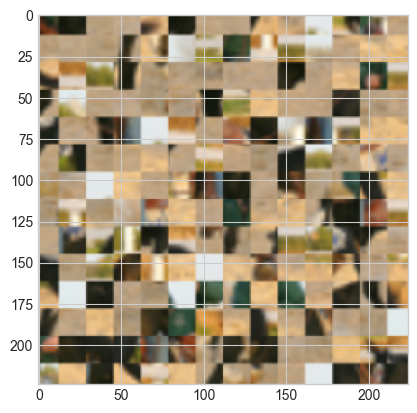

In [81]:
data, target = next(iter(permuted_test_loader))
img = data[0].permute(1, 2, 0).cpu().numpy()
plt.imshow((img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])).clip(0, 1))
plt.show()

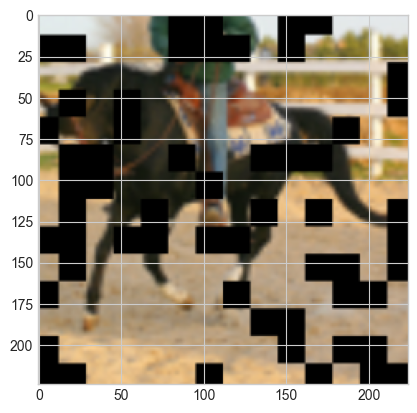

In [101]:
data, target = next(iter(occluded_test_loader))
img = data[0].permute(1, 2, 0).cpu().numpy()
plt.imshow((img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])).clip(0, 1))
plt.show()

In [82]:
resnet.eval()
correct_test_resnet = 0
total_test_resnet = 0
with torch.no_grad():
    pbar_resnet = tqdm(permuted_test_loader, desc="Evaluating ResNet-50 on Permuted Test Set")
    for data, target in pbar_resnet:
        data, target = data.to(device), target.to(device)
        output = resnet(data)
        _, predicted = torch.max(output.data, 1)
        total_test_resnet += target.size(0)
        correct_test_resnet += (predicted == target).sum().item()
        pbar_resnet.set_postfix({'accuracy': f"{100 * correct_test_resnet / total_test_resnet:.2f}%"})
resnet_permuted_acc = 100 * correct_test_resnet / total_test_resnet
print(f"Accuracy of ResNet-50 on Permuted Test Set: {resnet_permuted_acc:.2f}%")


Evaluating ResNet-50 on Permuted Test Set: 100%|██████████| 63/63 [00:50<00:00,  1.25it/s, accuracy=21.18%]

Accuracy of ResNet-50 on Permuted Test Set: 21.18%


In [84]:
vit.eval()
correct_test_vit = 0
total_test_vit = 0
with torch.no_grad():
    pbar_vit = tqdm(permuted_test_loader, desc="Evaluating ViT on Permuted Test Set")
    for data, target in pbar_vit:
        data, target = data.to(device), target.to(device)
        output = vit(data)
        _, predicted = torch.max(output.data, 1)
        total_test_vit += target.size(0)
        correct_test_vit += (predicted == target).sum().item()
        pbar_vit.set_postfix({'accuracy': f"{100 * correct_test_vit / total_test_vit:.2f}%"})
vit_permuted_acc = 100 * correct_test_vit / total_test_vit
print(f"Accuracy of ViT on Permuted Test Set: {vit_permuted_acc:.2f}%")

Evaluating ViT on Permuted Test Set: 100%|██████████| 63/63 [00:39<00:00,  1.58it/s, accuracy=20.19%]

Accuracy of ViT on Permuted Test Set: 20.19%


In [102]:
resnet.eval()
correct_test_resnet = 0
total_test_resnet = 0
with torch.no_grad():
    pbar_resnet = tqdm(occluded_test_loader, desc="Evaluating ResNet-50 on Occluded Test Set")
    for data, target in pbar_resnet:
        data, target = data.to(device), target.to(device)
        output = resnet(data)
        _, predicted = torch.max(output.data, 1)
        total_test_resnet += target.size(0)
        correct_test_resnet += (predicted == target).sum().item()
        pbar_resnet.set_postfix({'accuracy': f"{100 * correct_test_resnet / total_test_resnet:.2f}%"})
resnet_occluded_acc = 100 * correct_test_resnet / total_test_resnet
print(f"Accuracy of ResNet-50 on Occluded Test Set: {resnet_occluded_acc:.2f}%")

Evaluating ResNet-50 on Occluded Test Set: 100%|██████████| 63/63 [01:09<00:00,  1.10s/it, accuracy=75.39%]

Accuracy of ResNet-50 on Occluded Test Set: 75.39%


In [103]:
vit.eval()
correct_test_vit = 0
total_test_vit = 0
with torch.no_grad():
    pbar_vit = tqdm(occluded_test_loader, desc="Evaluating ViT on Occluded Test Set")
    for data, target in pbar_vit:
        data, target = data.to(device), target.to(device)
        output = vit(data)
        _, predicted = torch.max(output.data, 1)
        total_test_vit += target.size(0)
        correct_test_vit += (predicted == target).sum().item()
        pbar_vit.set_postfix({'accuracy': f"{100 * correct_test_vit / total_test_vit:.2f}%"})
vit_occluded_acc = 100 * correct_test_vit / total_test_vit
print(f"Accuracy of ViT on Occluded Test Set: {vit_occluded_acc:.2f}%")

Evaluating ViT on Occluded Test Set:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating ViT on Occluded Test Set: 100%|██████████| 63/63 [00:45<00:00,  1.37it/s, accuracy=83.30%]

Accuracy of ViT on Occluded Test Set: 83.30%



--- Processing Style: ABSTRACT ---


Extracting ResNet-50 features from abstract style: 100%|██████████| 1/1 [00:04<00:00,  4.11s/it]
Extracting ViT features from abstract style: 100%|██████████| 1/1 [00:33<00:00, 33.99s/it]


Running t-SNE for ResNet-50: abstract...


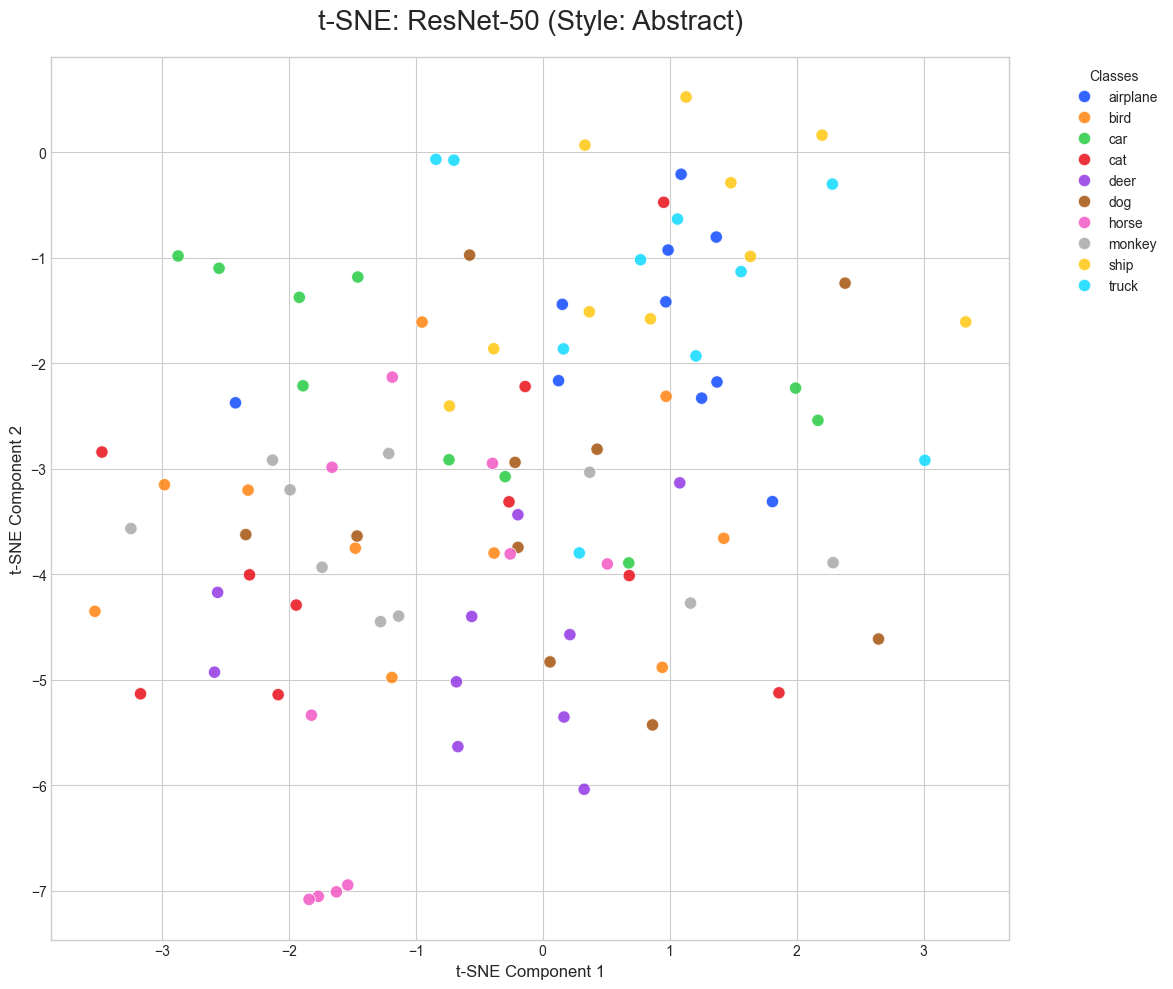

Running t-SNE for ViT: abstract...


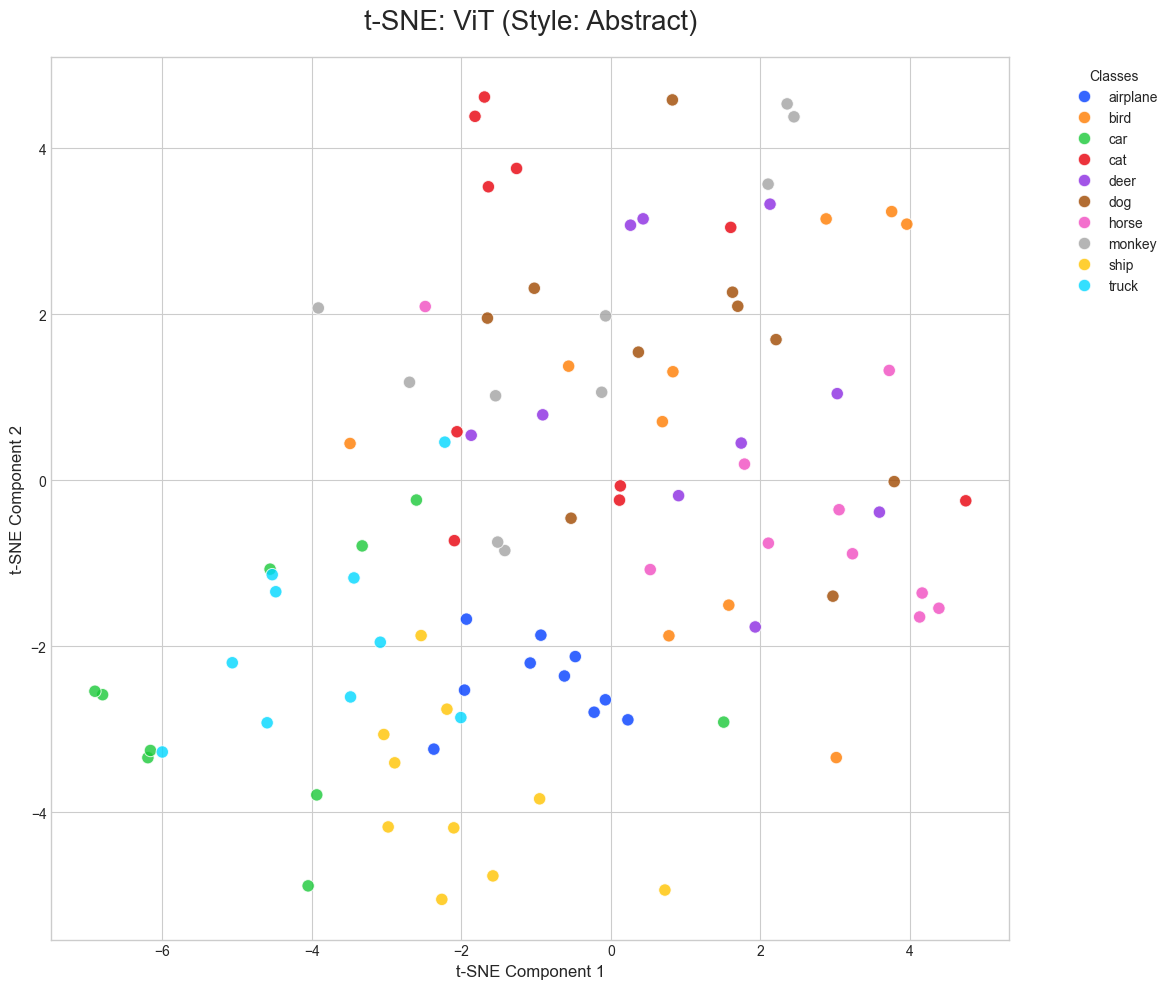


--- Processing Style: MOSAIC ---


Extracting ViT features from mosaic style: 100%|██████████| 1/1 [00:30<00:00, 30.16s/it]


Running t-SNE for ResNet-50: mosaic...


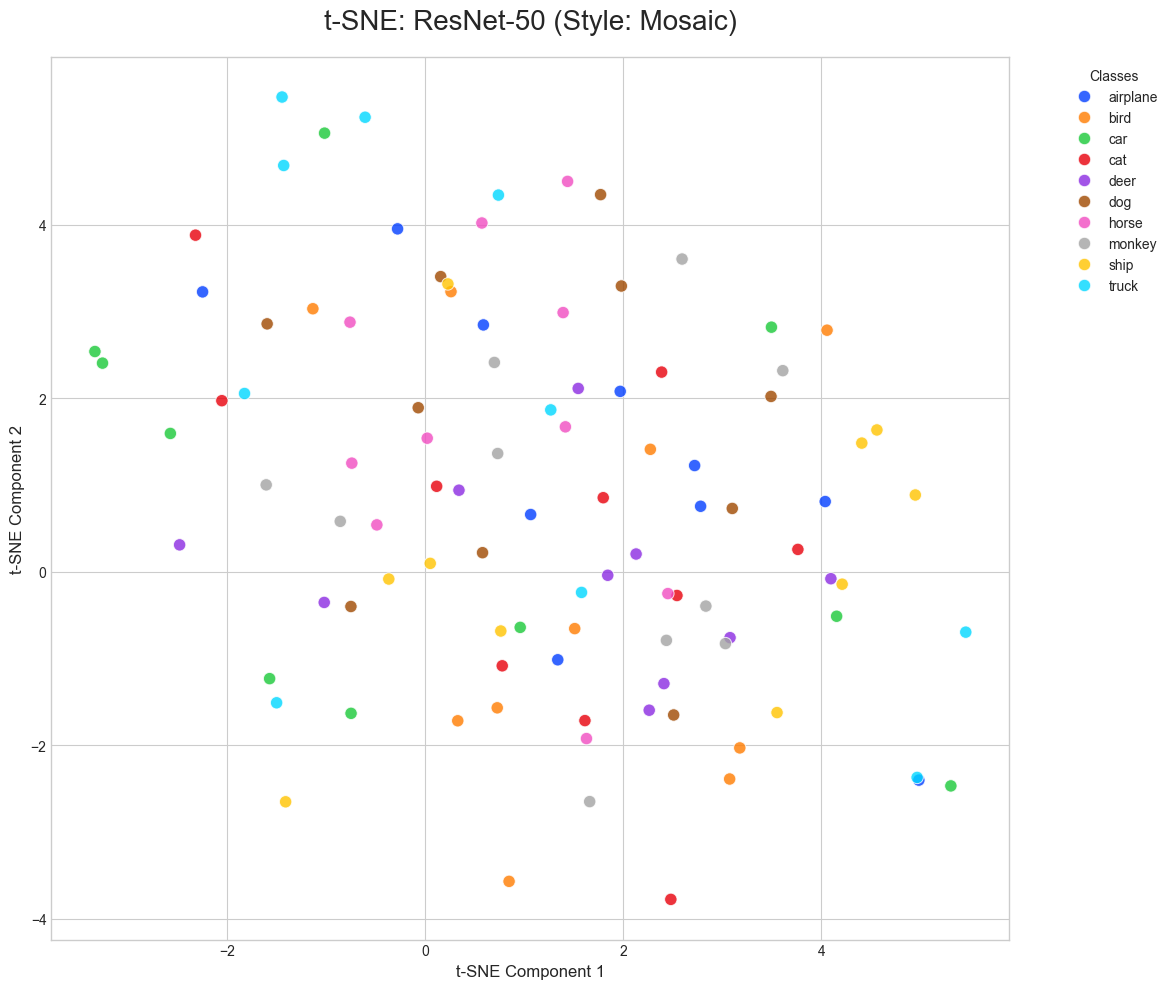

Running t-SNE for ViT: mosaic...


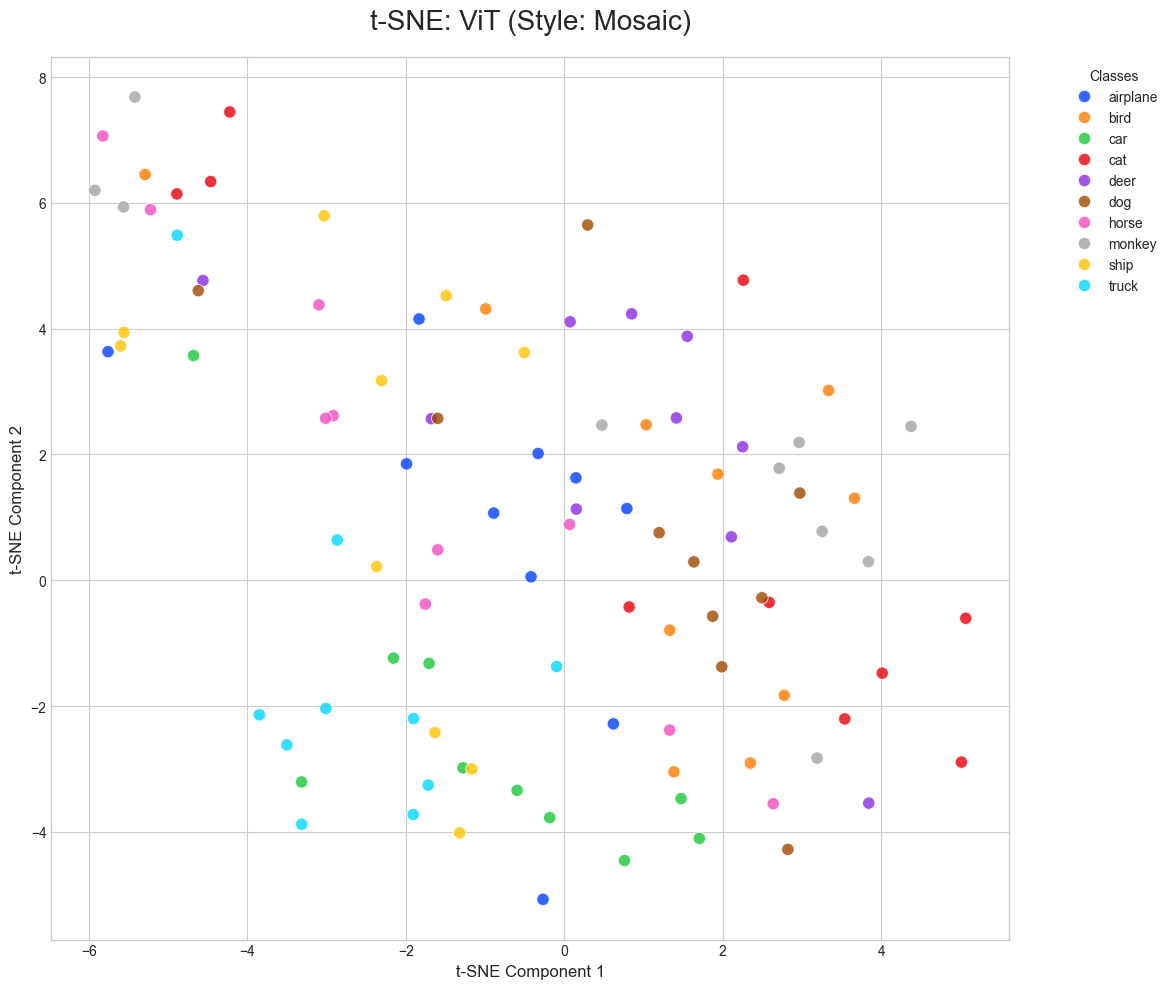


--- Processing Style: RAIN_PRINCESS ---


Extracting ResNet-50 features from rain_princess style: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]
Extracting ViT features from rain_princess style: 100%|██████████| 1/1 [00:03<00:00,  3.38s/it]


Running t-SNE for ResNet-50: rain_princess...


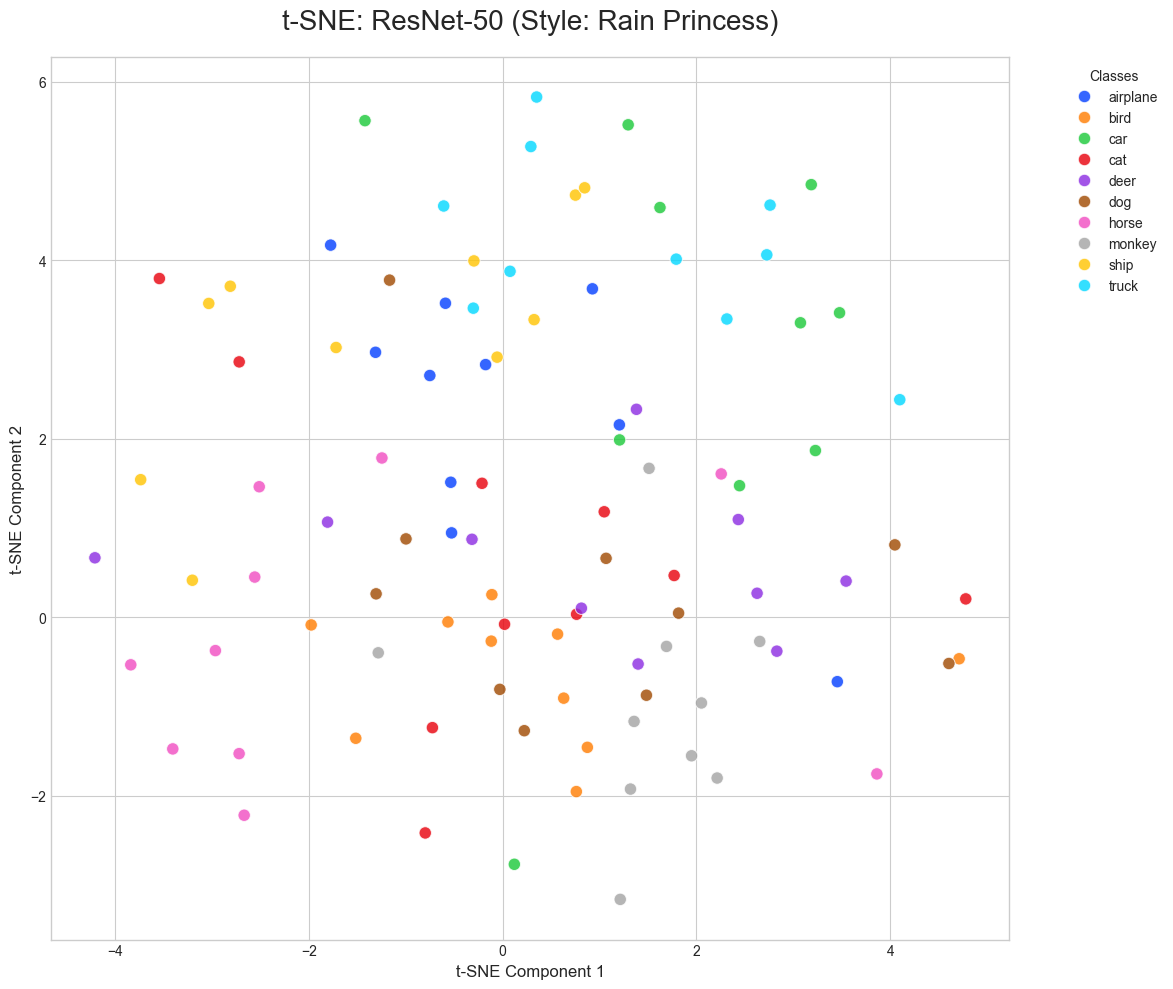

Running t-SNE for ViT: rain_princess...


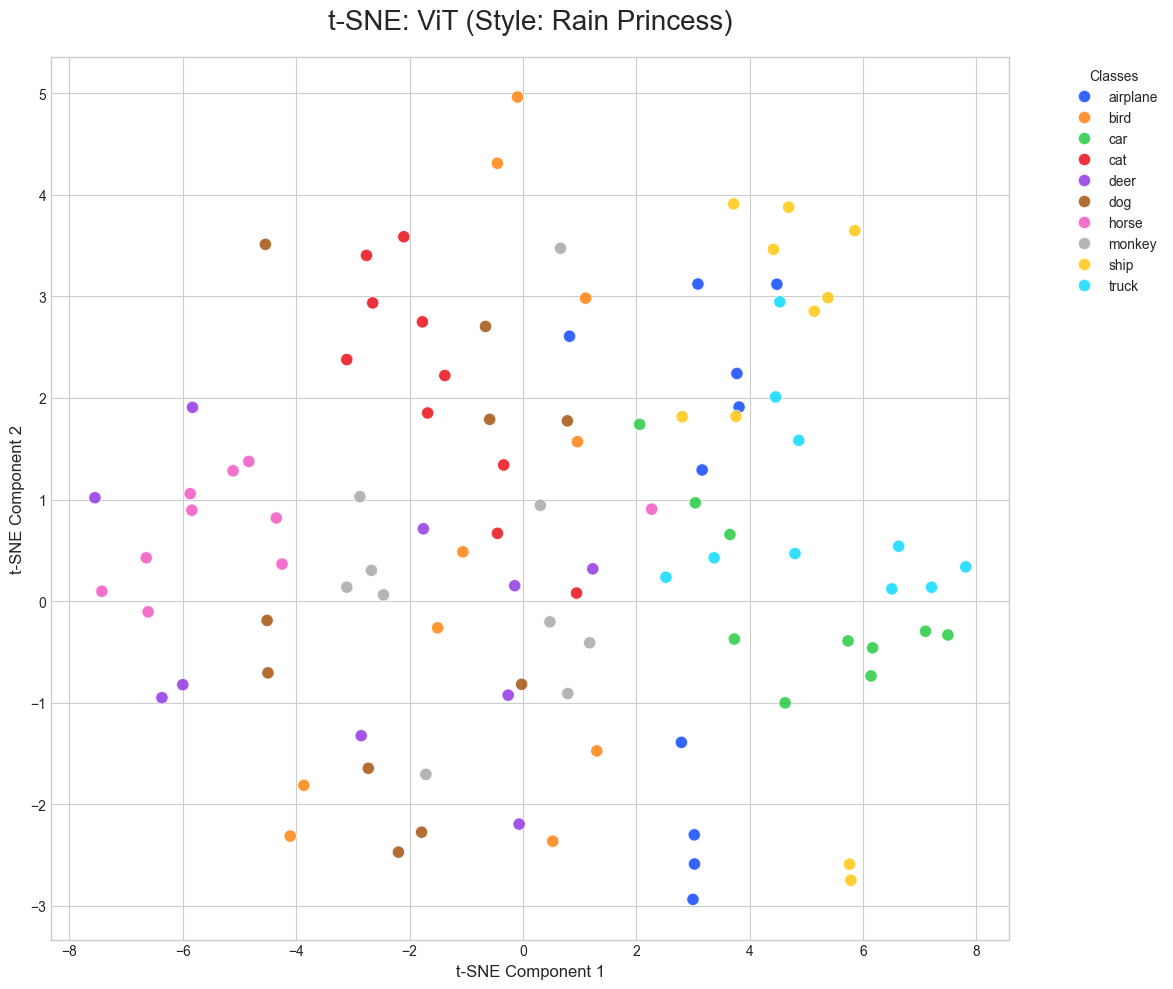


--- Processing Style: STARRY_NIGHT ---


Extracting ResNet-50 features from starry_night style: 100%|██████████| 1/1 [00:03<00:00,  3.24s/it]
Extracting ViT features from starry_night style: 100%|██████████| 1/1 [00:50<00:00, 50.14s/it]


Running t-SNE for ResNet-50: starry_night...


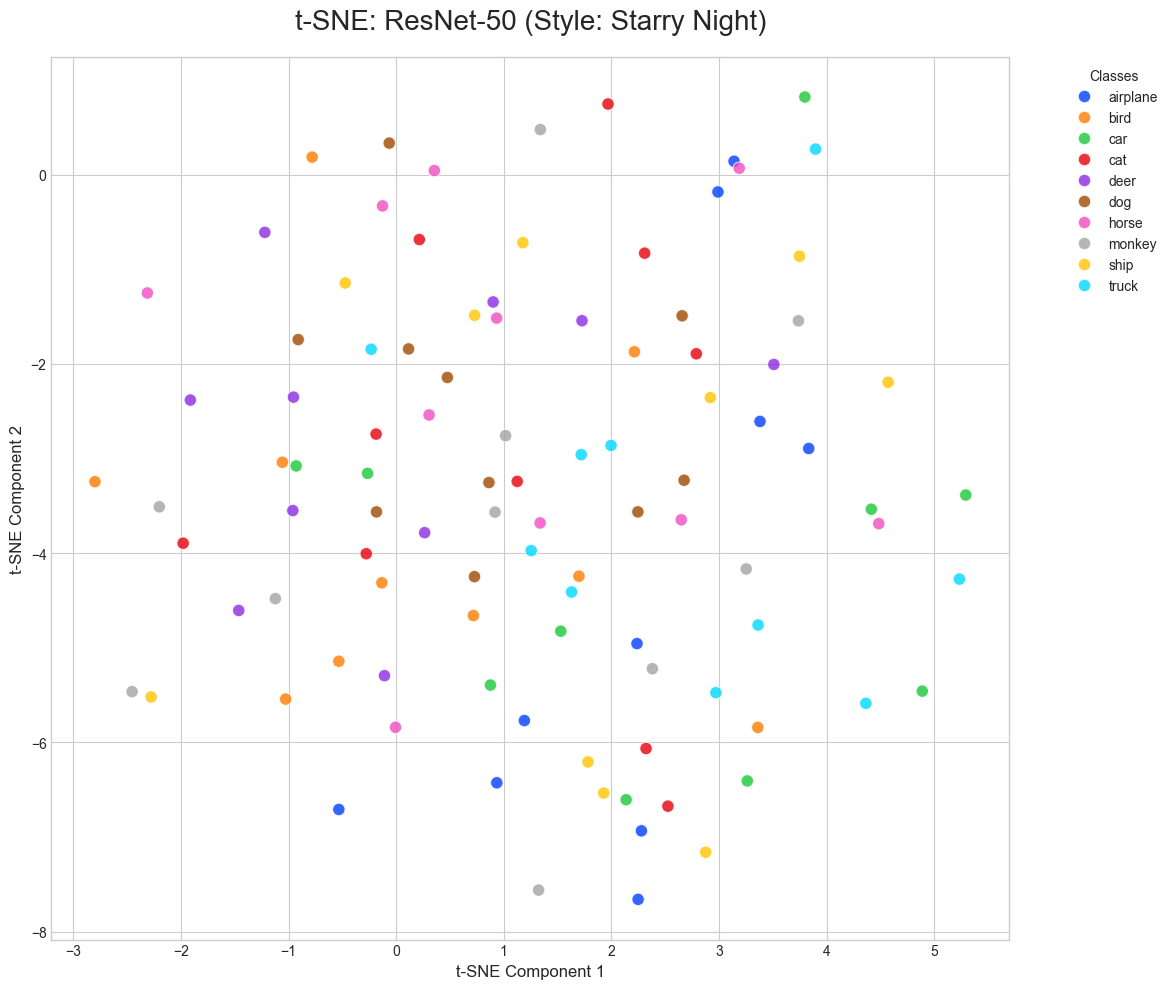

Running t-SNE for ViT: starry_night...


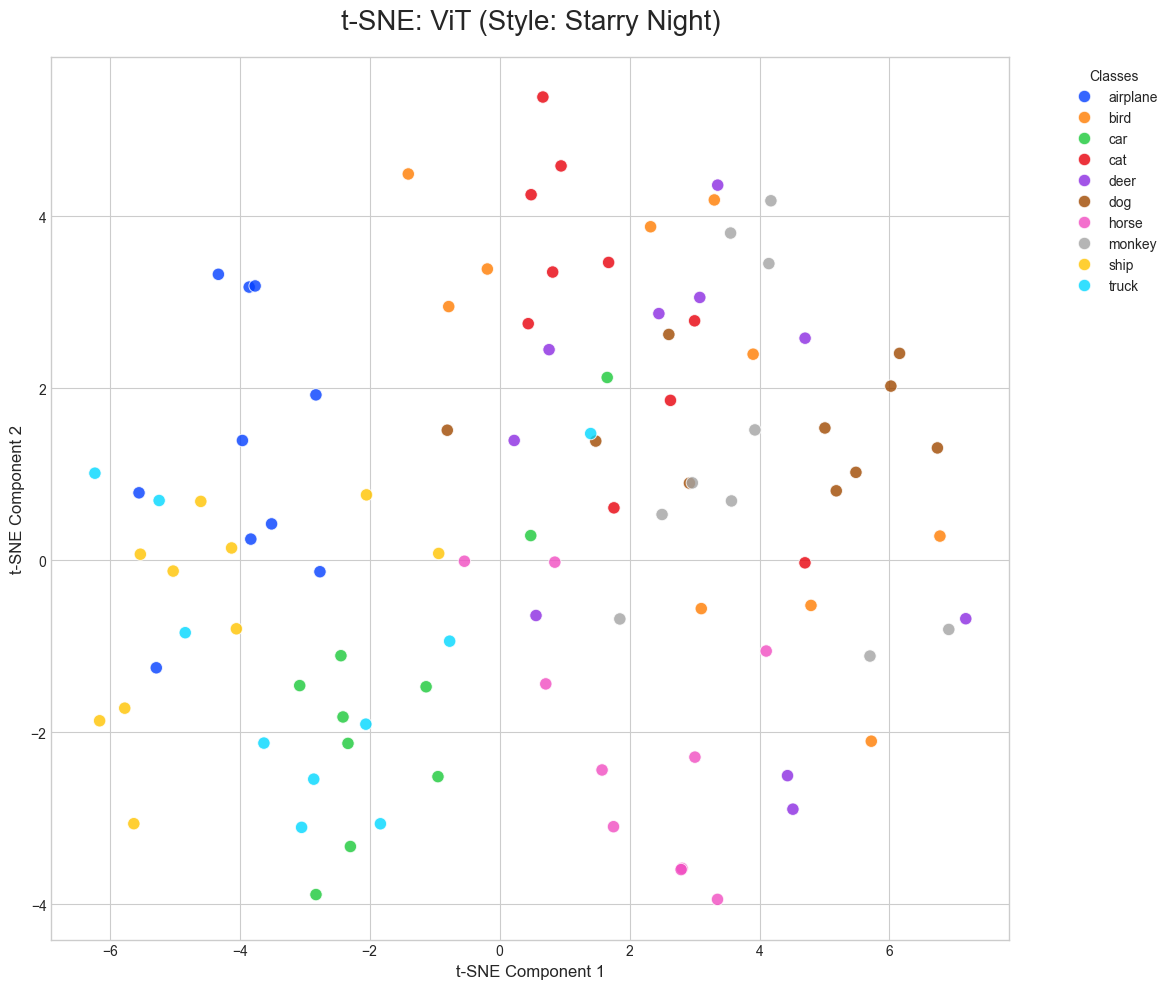

In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns
from torch.utils.data import Subset
import copy
cue_conflict_dir = "data/cue_conflict_dataset"
full_cue_conflict_dataset = datasets.ImageFolder(
    root=cue_conflict_dir,
    transform=transform
)


def extract_features(model, data_loader, device, model_name, dataset_name):
    features, labels = [], []
    def hook(module, input, output):
        features.append(input[0].detach().cpu().numpy())

    if isinstance(model, models.ResNet):
        handle = model.fc.register_forward_hook(hook)
    elif isinstance(model, timm.models.VisionTransformer):
        handle = model.head.register_forward_hook(hook)
    else:
        raise TypeError("Model type not supported.")

    with torch.no_grad():
        for imgs, lbls in tqdm(data_loader, desc=f"Extracting {model_name} features from {dataset_name}"):
            imgs = imgs.to(device)
            _ = model(imgs)
            labels.append(lbls.cpu().numpy())
    handle.remove()
    return np.concatenate(features), np.concatenate(labels)



def plot_tsne_single_style(features, labels, style_name, model_name, class_names):
    print(f"Running t-SNE for {model_name}: {style_name}...")
    tsne = TSNE(n_components=2, perplexity=30, max_iter=1000, random_state=42)
    tsne_results = tsne.fit_transform(features)

    plt.style.use("seaborn-v0_8-whitegrid")
    plt.figure(figsize=(14, 10))
    palette = sns.color_palette("bright", n_colors=len(class_names))

    sns.scatterplot(
        x=tsne_results[:, 0], y=tsne_results[:, 1], hue=labels,
        palette=palette, s=80, alpha=0.8, legend='full'
    )
    plt.title(f't-SNE: {model_name} (Style: {style_name.replace("_", " ").title()})', fontsize=20, pad=20)
    plt.xlabel('t-SNE Component 1', fontsize=12)
    plt.ylabel('t-SNE Component 2', fontsize=12)
    
    handles, labels = plt.gca().get_legend_handles_labels()
    class_labels = [class_names[int(l)] for l in labels if l.isdigit()]
    
    plt.legend(handles=handles, labels=class_labels, title='Classes', 
               bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()

styles = ['abstract', 'mosaic', 'rain_princess', 'starry_night']
class_names = full_cue_conflict_dataset.classes

for style in styles:
    print(f"\n--- Processing Style: {style.upper()} ---")

    style_dataset = copy.deepcopy(full_cue_conflict_dataset)
    
    style_samples = [s for s in full_cue_conflict_dataset.samples if f"style_{style}" in s[0]]
    
    style_dataset.samples = style_samples
    style_dataset.imgs = style_samples 
    
    style_loader = DataLoader(style_dataset, batch_size=256, shuffle=False)
    
    resnet_style_feat, resnet_style_lbl = extract_features(resnet, style_loader, device, "ResNet-50", f"{style} style")
    vit_style_feat, vit_style_lbl = extract_features(vit, style_loader, device, "ViT", f"{style} style")

    plot_tsne_single_style(resnet_style_feat, resnet_style_lbl, style, 'ResNet-50', class_names)
    plot_tsne_single_style(vit_style_feat, vit_style_lbl, style, 'ViT', class_names)

--- Extracting Features for ResNet-50 ---


Extracting ResNet-50 features from Grayscale: 100%|██████████| 5/5 [00:09<00:00,  1.90s/it]



--- Extracting Features for ViT ---


Extracting ViT features from Grayscale: 100%|██████████| 5/5 [01:05<00:00, 13.05s/it]



--- Generating Original vs. Grayscale Plots ---
Running t-SNE for ResNet-50: Original vs. Grayscale...


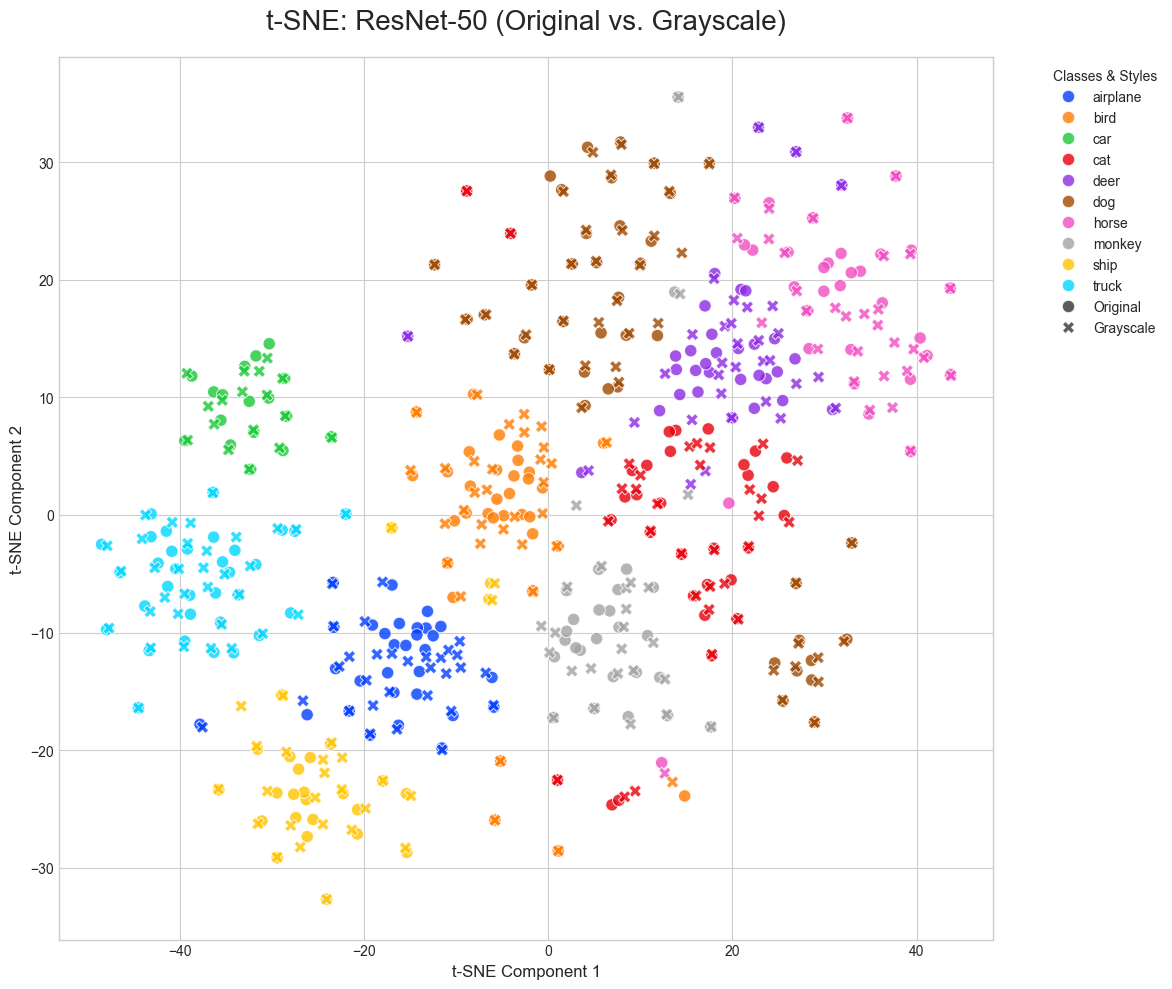

Running t-SNE for ViT: Original vs. Grayscale...


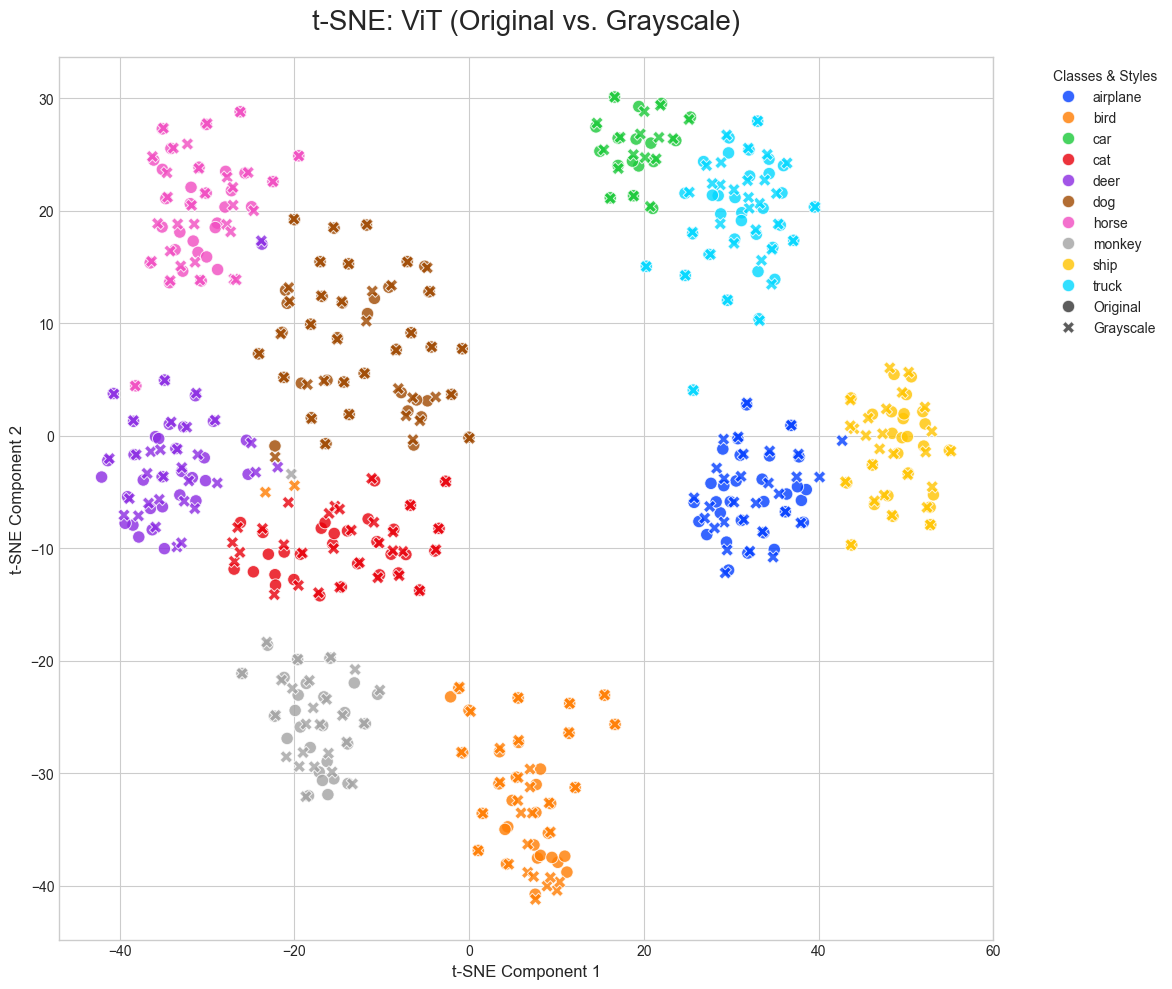

In [136]:
NUM_SAMPLES_PER_SET = 300
indices = list(range(len(test_dataset)))
random.shuffle(indices)
subset_indices = indices[:NUM_SAMPLES_PER_SET]

subset_test_loader = DataLoader(Subset(test_dataset, subset_indices), batch_size=64)
subset_grayscale_loader = DataLoader(Subset(grayscale_test_dataset, subset_indices), batch_size=64)

print("--- Extracting Features for ResNet-50 ---")
res_orig_feat, res_orig_lbl = extract_features(resnet, subset_test_loader, device, "ResNet-50", "Original")
res_gray_feat, res_gray_lbl = extract_features(resnet, subset_grayscale_loader, device, "ResNet-50", "Grayscale")

print("\n--- Extracting Features for ViT ---")
vit_orig_feat, vit_orig_lbl = extract_features(vit, subset_test_loader, device, "ViT", "Original")
vit_gray_feat, vit_gray_lbl = extract_features(vit, subset_grayscale_loader, device, "ViT", "Grayscale")

class_names = test_dataset.classes

def plot_tsne_comparison(features1, labels1, style1_name, features2, labels2, style2_name, model_name, class_names):
    """Applies t-SNE to TWO sets of features and creates a comparative plot."""
    all_features = np.concatenate([features1, features2])
    all_labels = np.concatenate([labels1, labels2])
    all_styles = [style1_name] * len(labels1) + [style2_name] * len(labels2)

    print(f"Running t-SNE for {model_name}: {style1_name} vs. {style2_name}...")
    tsne = TSNE(n_components=2, perplexity=30, max_iter=1000, random_state=42)
    tsne_results = tsne.fit_transform(all_features)

    plt.style.use("seaborn-v0_8-whitegrid")
    plt.figure(figsize=(14, 10))
    palette = sns.color_palette("bright", n_colors=len(class_names))
    markers = {style1_name: 'o', style2_name: 'X'}

    sns.scatterplot(
        x=tsne_results[:, 0], y=tsne_results[:, 1], hue=all_labels, style=all_styles,
        markers=markers, palette=palette, s=80, alpha=0.8, legend='full'
    )
    plt.title(f't-SNE: {model_name} ({style1_name} vs. {style2_name})', fontsize=20, pad=20)
    plt.xlabel('t-SNE Component 1', fontsize=12)
    plt.ylabel('t-SNE Component 2', fontsize=12)
    
    handles, labels = plt.gca().get_legend_handles_labels()
    
    class_handles = [h for h, l in zip(handles, labels) if l.isdigit()]
    style_handles = [h for h, l in zip(handles, labels) if l in markers.keys()]
    class_labels_str = [class_names[int(l)] for l in labels if l.isdigit()]
    style_labels_str = [l for l in labels if l in markers.keys()]
    
    plt.legend(handles=class_handles + style_handles, 
               labels=class_labels_str + style_labels_str, 
               title='Classes & Styles', 
               bbox_to_anchor=(1.05, 1), 
               loc='upper left')

    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()

print("\n--- Generating Original vs. Grayscale Plots ---")
plot_tsne_comparison(res_orig_feat, res_orig_lbl, 'Original', res_gray_feat, res_gray_lbl, 'Grayscale', 'ResNet-50', class_names)
plot_tsne_comparison(vit_orig_feat, vit_orig_lbl, 'Original', vit_gray_feat, vit_gray_lbl, 'Grayscale', 'ViT', class_names)

### Domain Generalisation

In [2]:
from torch.utils.data import ConcatDataset

device = "cuda" if torch.cuda.is_available() else "cpu"
data_dir = "data/PACS"
train_domains = ['P', 'A', 'C']
test_domain = 'S'
NUM_CLASSES_PACS = 7
BATCH_SIZE = 32
LEARNING_RATE = 1e-4
EPOCHS = 5

transform = weights.transforms()

train_datasets = [datasets.ImageFolder(os.path.join(data_dir, domain), transform=transform) for domain in train_domains]

combined_train_dataset = ConcatDataset(train_datasets)

test_dataset = datasets.ImageFolder(os.path.join(data_dir, test_domain), transform=transform)

train_loader = DataLoader(combined_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Combined training domains ({', '.join(train_domains)}): {len(combined_train_dataset)} images")
print(f"Test domain ({test_domain}): {len(test_dataset)} images")

Combined training domains (P, A, C): 6062 images
Test domain (S): 3929 images


In [3]:
resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
for param in resnet.parameters():
    param.requires_grad = False
resnet.fc = nn.Linear(resnet.fc.in_features, NUM_CLASSES_PACS)
resnet = resnet.to(device)
resnet_optimizer = optim.Adam(resnet.fc.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

In [4]:
resnet_train_losses = []
resnet_test_losses = []
resnet_train_accs = []
resnet_test_accs = []

for epoch in range(EPOCHS):
    resnet.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [ResNet Training]")
    for data, target in train_pbar:
        data, target = data.to(device), target.to(device)

        resnet_optimizer.zero_grad()
        output = resnet(data)
        loss = criterion(output, target)
        loss.backward()
        resnet_optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total_train += target.size(0)
        correct_train += (predicted == target).sum().item()
        train_pbar.set_postfix(
            {
                "loss": f"{running_loss/len(train_loader):.4f}",
                "acc": f"{100 * correct_train / total_train:.2f}%",
            }
        )

    epoch_train_loss = running_loss / len(train_loader)
    epoch_train_acc = correct_train / total_train
    resnet_train_losses.append(epoch_train_loss)
    resnet_train_accs.append(epoch_train_acc)

    resnet.eval()
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        test_pbar = tqdm(test_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [ResNet Testing]")
        for data, target in test_pbar:
            data, target = data.to(device), target.to(device)
            output = resnet(data)
            loss = criterion(output, target)
            test_loss += loss.item()

            _, predicted = torch.max(output.data, 1)
            total_test += target.size(0)
            correct_test += (predicted == target).sum().item()
            test_pbar.set_postfix(
                {
                    "loss": f"{test_loss/len(test_loader):.4f}",
                    "acc": f"{100 * correct_test / total_test:.2f}%",
                }
            )

    epoch_test_loss = test_loss / len(test_loader)
    epoch_test_acc = correct_test / total_test
    resnet_test_losses.append(epoch_test_loss)
    resnet_test_accs.append(epoch_test_acc)

    print(
        f"Epoch {epoch+1} Summary -> Train Acc: {epoch_train_acc*100:.2f}% | Test Acc: {epoch_test_acc*100:.2f}%"
    )   

Epoch 1/5 [ResNet Testing]: 100%|██████████| 123/123 [00:43<00:00,  2.82it/s, loss=1.7645, acc=32.81%]


Epoch 1 Summary -> Train Acc: 55.96% | Test Acc: 32.81%


Epoch 2/5 [ResNet Testing]: 100%|██████████| 123/123 [00:15<00:00,  7.86it/s, loss=1.6345, acc=39.83%]


Epoch 2 Summary -> Train Acc: 80.06% | Test Acc: 39.83%


Epoch 3/5 [ResNet Testing]: 100%|██████████| 123/123 [00:15<00:00,  7.85it/s, loss=1.5527, acc=43.98%]


Epoch 3 Summary -> Train Acc: 84.69% | Test Acc: 43.98%


Epoch 4/5 [ResNet Testing]: 100%|██████████| 123/123 [00:15<00:00,  7.82it/s, loss=1.5063, acc=45.81%]


Epoch 4 Summary -> Train Acc: 86.92% | Test Acc: 45.81%


Epoch 5/5 [ResNet Testing]: 100%|██████████| 123/123 [00:15<00:00,  7.86it/s, loss=1.4830, acc=45.25%]

Epoch 5 Summary -> Train Acc: 87.58% | Test Acc: 45.25%


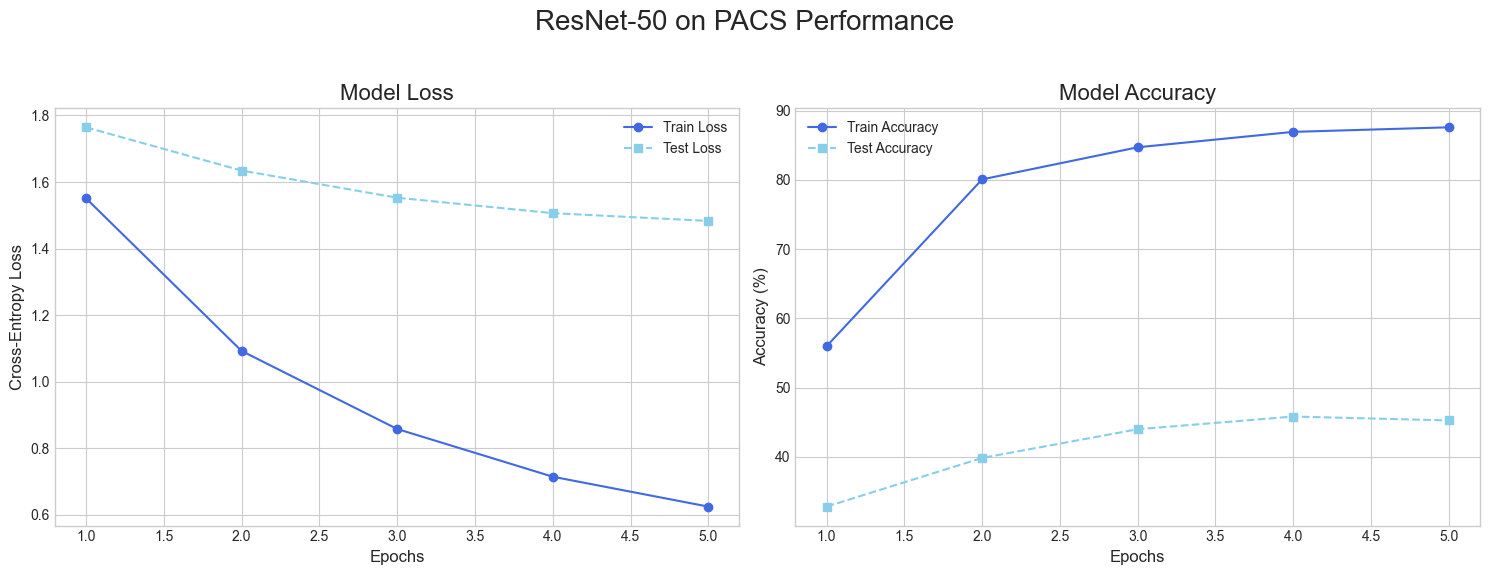

In [5]:
epochs = range(1, EPOCHS + 1)
plt.style.use("seaborn-v0_8-whitegrid")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle("ResNet-50 on PACS Performance", fontsize=20)
# Plotting Loss
ax1.plot(epochs, resnet_train_losses, "o-", label="Train Loss", color="royalblue")
ax1.plot(epochs, resnet_test_losses, "s--", label="Test Loss", color="skyblue")
ax1.set_title("Model Loss", fontsize=16)
ax1.set_xlabel("Epochs", fontsize=12)
ax1.set_ylabel("Cross-Entropy Loss", fontsize=12)
ax1.legend()
# Plotting Accuracy
ax2.plot(
    epochs,
    [acc * 100 for acc in resnet_train_accs],
    "o-",
    label="Train Accuracy",
    color="royalblue",
)
ax2.plot(
    epochs,
    [acc * 100 for acc in resnet_test_accs],
    "s--",
    label="Test Accuracy",
    color="skyblue",
)
ax2.set_title("Model Accuracy", fontsize=16)
ax2.set_xlabel("Epochs", fontsize=12)
ax2.set_ylabel("Accuracy (%)", fontsize=12)
ax2.legend()
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [6]:
vit = timm.create_model('vit_small_patch16_224', pretrained=True)
for param in vit.parameters():
    param.requires_grad = False
vit.head = nn.Linear(vit.head.in_features, NUM_CLASSES_PACS)
vit = vit.to(device)
vit_optimizer = optim.Adam(vit.head.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

In [7]:
vit_train_losses = []
vit_test_losses = []
vit_train_accs = []
vit_test_accs = []

for epoch in range(EPOCHS):
    vit.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [ViT Training]")
    for data, target in train_pbar:
        data, target = data.to(device), target.to(device)

        vit_optimizer.zero_grad()
        output = vit(data)
        loss = criterion(output, target)
        loss.backward()
        vit_optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total_train += target.size(0)
        correct_train += (predicted == target).sum().item()
        train_pbar.set_postfix(
            {
                "loss": f"{running_loss/len(train_loader):.4f}",
                "acc": f"{100 * correct_train / total_train:.2f}%",
            }
        )

    epoch_train_loss = running_loss / len(train_loader)
    epoch_train_acc = correct_train / total_train
    vit_train_losses.append(epoch_train_loss)
    vit_train_accs.append(epoch_train_acc)

    vit.eval()
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        test_pbar = tqdm(test_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [ViT Testing]")
        for data, target in test_pbar:
            data, target = data.to(device), target.to(device)
            output = vit(data)
            loss = criterion(output, target)
            test_loss += loss.item()

            _, predicted = torch.max(output.data, 1)
            total_test += target.size(0)
            correct_test += (predicted == target).sum().item()
            test_pbar.set_postfix(
                {
                    "loss": f"{test_loss/len(test_loader):.4f}",
                    "acc": f"{100 * correct_test / total_test:.2f}%",
                }
            )

    epoch_test_loss = test_loss / len(test_loader)
    epoch_test_acc = correct_test / total_test
    vit_test_losses.append(epoch_test_loss)
    vit_test_accs.append(epoch_test_acc)

    print(  
        f"Epoch {epoch+1} Summary -> Train Acc: {epoch_train_acc*100:.2f}%, Test Acc: {epoch_test_acc*100:.2f}%"
    )


Epoch 1/5 [ViT Testing]: 100%|██████████| 123/123 [00:24<00:00,  4.95it/s, loss=2.0888, acc=22.86%]


Epoch 1 Summary -> Train Acc: 40.25%, Test Acc: 22.86%


Epoch 2/5 [ViT Testing]: 100%|██████████| 123/123 [00:24<00:00,  5.08it/s, loss=2.1195, acc=21.00%]


Epoch 2 Summary -> Train Acc: 74.89%, Test Acc: 21.00%


Epoch 3/5 [ViT Testing]: 100%|██████████| 123/123 [00:18<00:00,  6.62it/s, loss=2.1495, acc=17.00%]


Epoch 3 Summary -> Train Acc: 82.53%, Test Acc: 17.00%


Epoch 4/5 [ViT Testing]: 100%|██████████| 123/123 [00:13<00:00,  8.81it/s, loss=2.1874, acc=15.58%]


Epoch 4 Summary -> Train Acc: 86.21%, Test Acc: 15.58%


Epoch 5/5 [ViT Testing]: 100%|██████████| 123/123 [00:22<00:00,  5.48it/s, loss=2.1955, acc=15.47%]

Epoch 5 Summary -> Train Acc: 87.94%, Test Acc: 15.47%
